Cifar 100. Took a code from Kaggle and added WandB monitoring. Checked prediction.

In [ ]:
# Importing the required libraries and dataset
import os
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide all TensorFlow debugging logs

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
run = wandb.init(project='MLOPS-mini-cap-cifar')

wandb: Currently logged in as: nrepesh (use `wandb login --relogin` to force relogin)


In [ ]:
# Load dataset and pre-process data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

169017344/169001437 [==============================] - 3s 0us/step


In [ ]:
# Split the data into test and validation data
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [ ]:
# Dataset class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
# Convert labels to one hot encoding matrix
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

In [ ]:
# Function for model building
def build_model(input_shape, n_classes):
    """
    Build model from DenseNet. Retrain last 5 layers and adds 2 Dense layers.
    :param input_shape: shape of single image
    :param n_classes: number of classes for prediction
    :return model: compiled model
    """
    base_model = densenet.DenseNet121(input_shape=input_shape,
                                      weights="imagenet",
                                      include_top=False,
                                      pooling='avg')

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output

    x = Dense(128)(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Build model and get summary
model = build_model(input_shape=(32, 32, 3), n_classes=len(labels))
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']             
                             

In [ ]:
# Generate augmented images
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)

In [ ]:
# Set checkpointer and train model
model_checkpointer = ModelCheckpoint('cifar100_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True), 
    validation_data=(X_valid, y_valid),
    epochs=60, 
    verbose=1,  
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15), 
               model_checkpointer,WandbCallback()])

Epoch 1/60
391/391 [==============================] - ETA: 0s - loss: 3.6570 - accuracy: 0.1622
Epoch 00001: val_accuracy improved from -inf to 0.26100, saving model to cifar100_best_model.h5
391/391 [==============================] - 79s 158ms/step - loss: 3.6570 - accuracy: 0.1622 - val_loss: 2.9944 - val_accuracy: 0.2610
Epoch 2/60
391/391 [==============================] - ETA: 0s - loss: 3.1018 - accuracy: 0.2447
Epoch 00002: val_accuracy improved from 0.26100 to 0.29786, saving model to cifar100_best_model.h5
391/391 [==============================] - 58s 147ms/step - loss: 3.1018 - accuracy: 0.2447 - val_loss: 2.7980 - val_accuracy: 0.2979
Epoch 3/60
391/391 [==============================] - ETA: 0s - loss: 2.9662 - accuracy: 0.2658
Epoch 00003: val_accuracy improved from 0.29786 to 0.32871, saving model to cifar100_best_model.h5
391/391 [==============================] - 57s 145ms/step - loss: 2.9662 - accuracy: 0.2658 - val_loss: 2.6501 - val_accuracy: 0.3287
Epoch 4/60
391/3

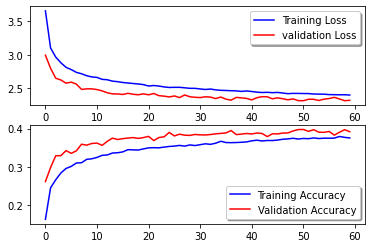

In [13]:
# Show Loss and Accuracy Plots
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation Loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [14]:
# Evaluate model on validation data
_, evaluation_score = model.evaluate(X_test, y_test)
print(f'Evaluation Score: {int(evaluation_score * 100)} %')

94/94 [==============================] - 4s 42ms/step - loss: 2.3454 - accuracy: 0.3850
Evaluation Score: 38 %


In [15]:
run.join()

accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇█████████
val_loss,█▆▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.37534
best_epoch,50
best_val_loss,2.31423
epoch,59
loss,2.39888
val_accuracy,0.39157


In [16]:
# Get classification report
pred = np.argmax(model.predict(X_test), axis=1)
test_y = np.argmax(y_test, axis=1)

print(classification_report(test_y, pred, labels=list(range(len(labels)))))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.51      0.51      0.51        37
           2       0.30      0.19      0.23        32
           3       0.17      0.22      0.19        23
           4       0.10      0.10      0.10        29
           5       0.25      0.39      0.31        28
           6       0.35      0.19      0.25        31
           7       0.45      0.56      0.50        27
           8       0.29      0.63      0.40        27
           9       0.45      0.44      0.44        32
          10       0.22      0.27      0.24        22
          11       0.43      0.11      0.18        27
          12       0.42      0.42      0.42        33
          13       0.20      0.22      0.21        32
          14       0.41      0.37      0.39        30
          15       0.25      0.11      0.15        36
          16       0.57      0.48      0.52        25
          17       0.46    

In [17]:
# Get the names of the class labels
labels_names = []
for i in range(len(labels)):
    labels_names += [i]
    
reverse_mapping = dict(zip(labels_names, labels)) 

def mapper(value):
    return reverse_mapping[value]

In [19]:
# Pre-process image
image_1 = load_img('/content/photo-1585110396000-c9ffd4e4b308.jpg', target_size=(32, 32))
image_1 = img_to_array(image_1) 
image_1 = image_1 / 255.0
prediction_image_1 = np.array(image_1)
prediction_image_1 = np.expand_dims(image_1, axis=0)

In [20]:
# Get prediction
prediction_1 = model.predict(prediction_image_1)
value_1 = np.argmax(prediction_1)
name_1 = mapper(value_1)
print(f'Prediction is {name_1}.')

Prediction is mushroom.
